In [1]:
from dgpsi import dgp, kernel, combine, lgp, path, emulator
import numpy as np
import matplotlib.pyplot as plt

Train for a 2-D non-stationary function

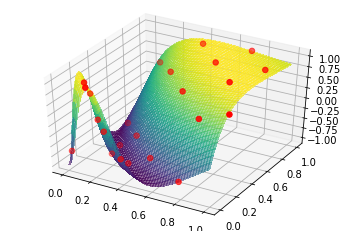

In [2]:
f= lambda x, y: np.sin(1/((0.7*x+0.3)*(0.7*y+0.3)))
# Make data.
X = np.arange(0, 1, 0.005)
Y = np.arange(0, 1, 0.005)
X, Y = np.meshgrid(X, Y)
Z = f(X,Y)
# Plot the surface.
X1=np.array([0,.02,.075,.08,.14,.15,.155,.156,.18,.22,.29,.32,.36, .37,.42,.5,.57,.63,.72,.785,.8,.84,.925,1])
X2=np.array([.29,.02,.12,.58,.38,.87,.01,.12,.22,.08,.34,.185,.64, .02,.93,.15,.42,.71,1,0,.21,.5,.785,.21])
fig = plt.figure()
ax = fig.gca(projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none',
                       linewidth=0, antialiased=False,alpha=0.6)
ax.scatter(X1,X2,f(X1,X2),color='r',s=30)
ax.view_init(elev=40., azim=-60)

In [3]:
#Construct a 4-layered DGP model with first three layers with 2 nodes and final layer with only one node. We also connect the global input to all nodes from the 2nd layer. One may try other structures while trade off the speed and structure complexity.
X=np.stack((X1,X2)).T
Y=f(X1,X2).reshape([-1,1])
layer1=[kernel(length=np.array([1]),name='sexp'),kernel(length=np.array([1]),name='sexp')]
layer2=[kernel(length=np.array([1]),name='sexp',connect=np.arange(2)),kernel(length=np.array([1]),name='sexp',connect=np.arange(2))]
layer3=[kernel(length=np.array([1]),name='sexp',connect=np.arange(2)),kernel(length=np.array([1]),name='sexp',connect=np.arange(2))]
layer4=[kernel(length=np.array([1]),name='sexp',scale_est=1,connect=np.arange(2))]
all_layer=combine(layer1,layer2,layer3,layer4)
m=dgp(X,[Y],all_layer)

In [4]:
#Train
m.train(N=500)

Iteration 500: Layer 4: 100%|██████████| 500/500 [01:34<00:00,  5.29it/s]


In [6]:
#Construct emulator
final_layer_obj=m.estimate()
emu=emulator(final_layer_obj)

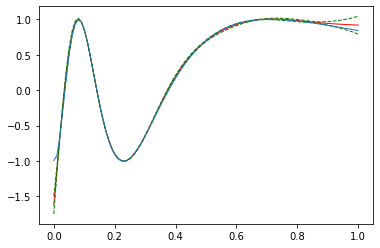

In [7]:
#Make predictions over the trace
z1=np.linspace(0,1,100)[:,None].reshape(-1,1)
z2=z1
z=np.concatenate((z1,z2),axis=1)
z0=np.linspace(0,1,100)[:,None]
mu,var=emu.predict(x=z, N=100, method='mean_var')
s=np.sqrt(var)
u=mu+2*s
l=mu-2*s
p=plt.plot(z0,mu,color='r',alpha=1,lw=1)
p1=plt.plot(z0,u,'--',color='g',lw=1)
p1=plt.plot(z0,l,'--',color='g',lw=1)
plt.plot(z0,f(z1,z2), linewidth=1)